In [1]:
import sys

sys.path.append('../..')
sys.path

['/opt/anaconda/envs/diffLIME/lib/python39.zip',
 '/opt/anaconda/envs/diffLIME/lib/python3.9',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/setuptools/_vendor',
 '../..']

In [2]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


2024-12-26 10:12:04.984200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735204324.998644   11675 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735204325.002984   11675 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 10:12:05.016960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument 

In [3]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]

Dataset CWRU already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Reading data: 100%|██████████| 161/161 [00:02<00:00, 58.97it/s] 
INFO:root:Read in 5.0591089725494385 seconds
INFO:root:It is possible stratified split? True
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: fault,DE,unit
INFO:root:Train shape: (28567988, 3)
INFO:root:Val shape: (7804030, 3)
INFO:root:Test shape: (979629, 3)


In [4]:
from phm_framework.data import prepare_data

X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=100000)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)


X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=100000)



INFO:root:Meta-attributes extracted in 108.82100868225098 seconds
INFO:root:Meta-attributes extracted in 28.138440132141113 seconds


In [8]:
from phm_framework.data import synthetic


X = X_train 

N4cluster = 1000

# Shuffle the indices of the dataset
indexes = np.arange(1, X.shape[0])
np.random.shuffle(indexes)

# Extract envelopes from detrended signals for clustering
envolventes = [synthetic.extract_envelopes(synthetic.eliminar_pendiente(X[indexes[i]])) for i in range(N4cluster)]
series_temporales = np.array(envolventes)[:N4cluster, :, :]


labels, centroids, stds, kmeans = synthetic.clusterizar_series_temporales(series_temporales, n_clusters=3, 
                                                                          metric='dtw')

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
dist = synthetic.generate_distributions(X_train, centroids, chunks=10, top_n=5)

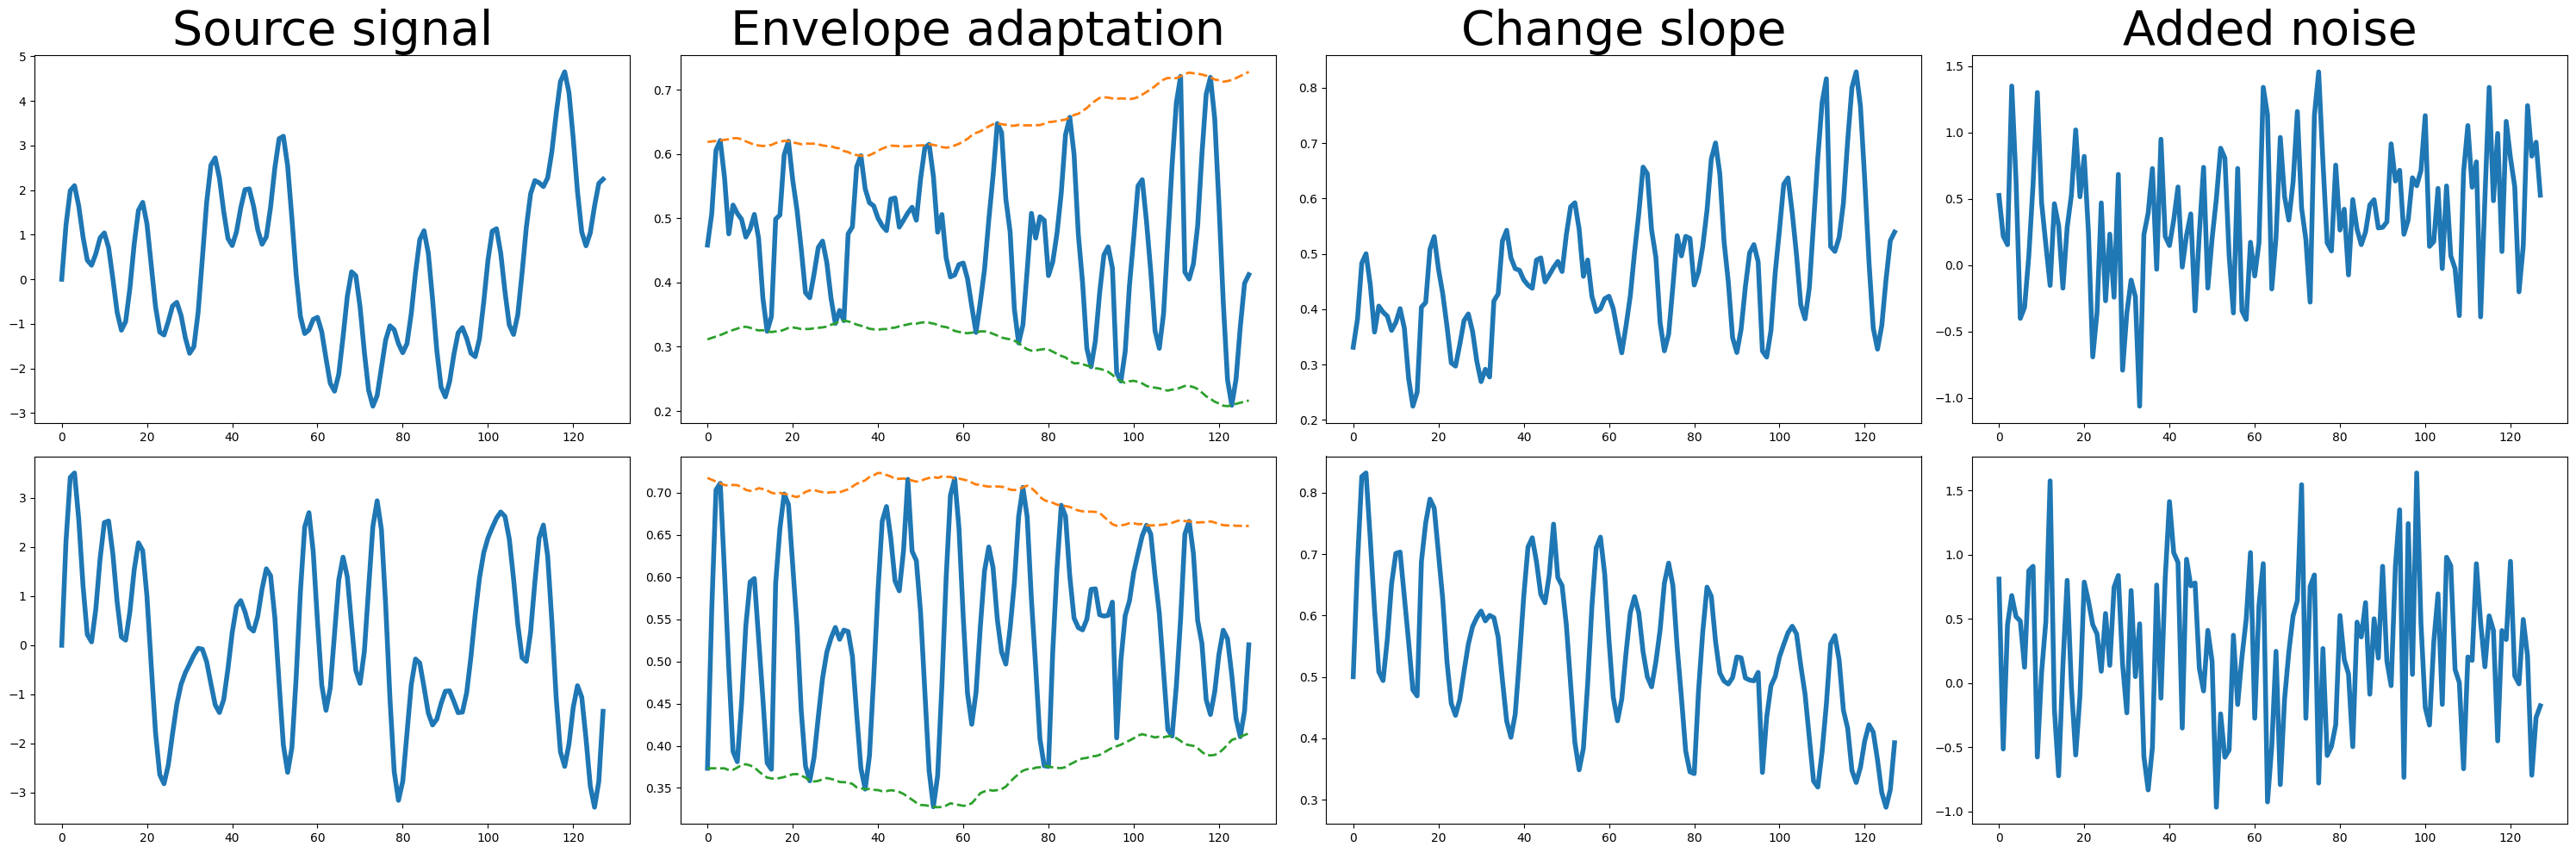

In [82]:
frequencies = [np.random.normal(d['frec_dist'][0], d['frec_dist'][1])  for d in dist[10]]
 
    
n_rows = 2
n_cols = 4

fig = plt.figure(figsize=(30, n_rows * 5))  # Ajustar tamaño según filas

time = np.linspace(0, 10, X.shape[1])

s = np.zeros((128,))
for f in frequencies:
    s += np.sin(time * f * 2 * np.pi * 5)

    
    
ax = plt.subplot(n_rows, n_cols, 1)  # Configurar subplot
ax.plot(s, linewidth=4)
ax.set_title("Source signal", fontsize=40)

ax = plt.subplot(n_rows, n_cols, 2)  # Configurar subplot
s2, _ = synthetic.adjust_to_envelopes_preserving_shape(s, centroids[0][0], centroids[0][1])

ax.plot(s2, linewidth=4)
ax.plot(centroids[0][0], linewidth=2, linestyle="--")
ax.plot(centroids[0][1], linewidth=2, linestyle="--")
ax.set_title("Envelope adaptation", fontsize=40)

ax = plt.subplot(n_rows, n_cols, 3)  # Configurar subplot
s3 = synthetic.adjust_slope(s2, 0.002)
ax.plot(s3, linewidth=4)
ax.set_title("Change slope", fontsize=40)

ax = plt.subplot(n_rows, n_cols, 4)  # Configurar subplot
s4 = synthetic.add_noise(s3, 0.002)
ax.plot(s4, linewidth=4)
ax.set_title("Added noise", fontsize=40)

frequencies = [np.random.normal(d['frec_dist'][0], d['frec_dist'][1])  for d in dist[20]]
     
s = np.zeros((128,))
for f in frequencies:
    s += np.sin(time * f * 2 * np.pi * 5)

    
ax = plt.subplot(n_rows, n_cols, 5)  # Configurar subplot
ax.plot(s, linewidth=4)

ax = plt.subplot(n_rows, n_cols, 6)  # Configurar subplot
s2, _ = synthetic.adjust_to_envelopes_preserving_shape(s, centroids[1][0], centroids[1][1])

ax.plot(s2, linewidth=4)
ax.plot(centroids[1][0], linewidth=2, linestyle="--")
ax.plot(centroids[1][1], linewidth=2, linestyle="--")

ax = plt.subplot(n_rows, n_cols, 7)  # Configurar subplot
s3 = synthetic.adjust_slope(s2, -0.002)
ax.plot(s3, linewidth=4)

ax = plt.subplot(n_rows, n_cols, 8)  # Configurar subplot
s4 = synthetic.add_noise(s3, 0.002)
ax.plot(s4, linewidth=4)

plt.tight_layout()
plt.savefig('signal_gen.pdf')